# Explore International Football Match data

In [45]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading and pruning

First load the rankings and results. From the match data, we drop all matches before 1993 since the FIFA rankings didn't exist before that.

In [46]:
folder = '/l/kaggle/int-football/'
rankings = pd.read_csv(os.path.join(folder, 'fifa_ranking-2024-06-20.csv'))

former_names = pd.read_csv(os.path.join(folder, 'former_names.csv'))
# Replace former names with current names in the rankings
rankings = rankings.merge(former_names, how='left', left_on='country_full', right_on='former')
rankings['country_full'] = rankings['country_full'].fillna(rankings['country_full'])
rankings = rankings.drop(columns=['former'])

rankings = rankings.replace({"IR Iran": "Iran"})
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

In [47]:
matches = pd.read_csv(os.path.join(folder, 'results.csv'))
# From results, drop all mathces before 1993 because we don't have rankings for them
matches['date'] = pd.to_datetime(matches['date'])
matches = matches[matches['date'] >= '1993-01-01']

Now, we add the fifa rating points to the results dataframe as two new columns: home_rating, away_rating.

In [48]:
# Rankings for every day
rankings = rankings.set_index(['rank_date'])
rankings = rankings.groupby('country_full', group_keys=False).resample('D').first().ffill().reset_index()

In [49]:
# Join the rankings with the matches
# First, home team
matches = matches.merge(rankings, how='left', left_on=['date', 'home_team'], right_on=['rank_date', 'country_full'])

# Then, away team
matches = matches.merge(rankings, how='left', left_on=['date', 'away_team'], right_on=['rank_date', 'country_full'], suffixes=('_home', '_away'))

In [77]:
# Generate some features
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['point_difference'] = matches['total_points_home'] - matches['total_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0
matches['is_won_or_draw'] = matches['score_difference'] >= 0

## Data visualization

(-350.0, 350.0)

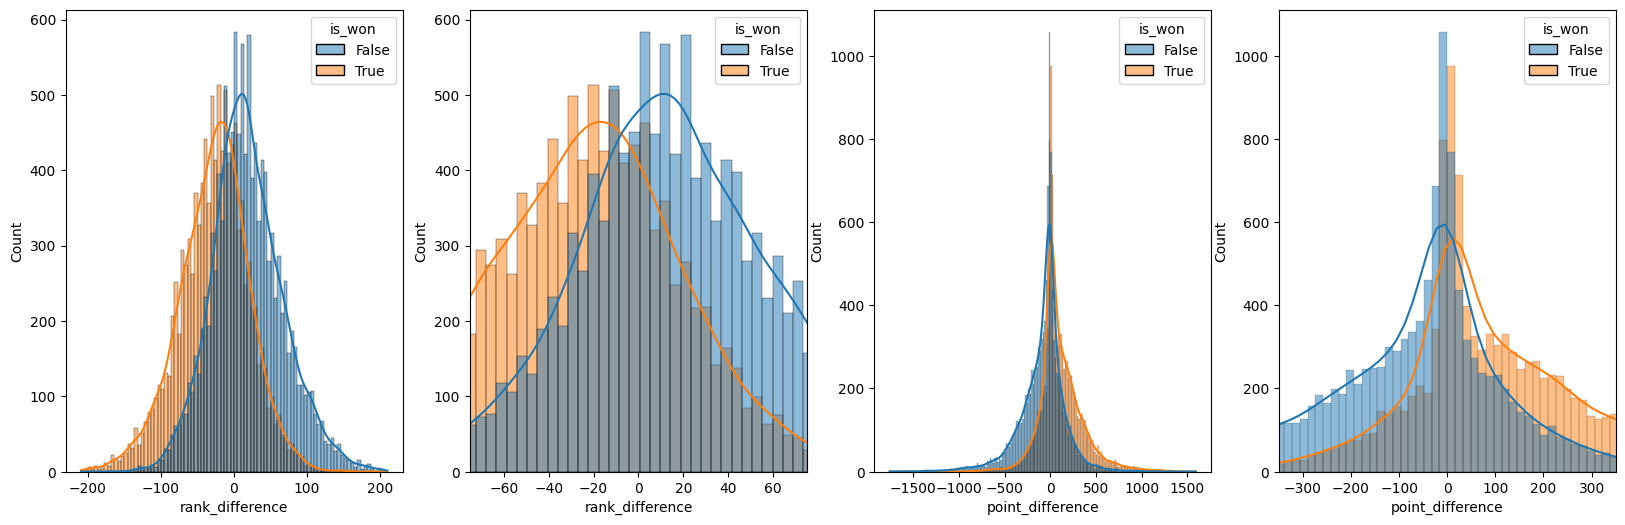

In [79]:
# Let's see how the rank and point differences are distributed
plt.figure(figsize=(20, 6))
ax = plt.subplot(141)
sns.histplot(data=matches, x='rank_difference', kde=True, hue='is_won', ax=ax)

# Do a close-up of the rank difference near zero
ax = plt.subplot(142)
sns.histplot(data=matches, x='rank_difference', kde=True, hue='is_won', ax=ax)
ax.set_xlim(-75, 75)

ax = plt.subplot(143)
sns.histplot(data=matches, x='point_difference', kde=True, hue='is_won', ax=ax)

# Do a close-up of the point difference near zero
ax = plt.subplot(144)
sns.histplot(data=matches, x='point_difference', kde=True, hue='is_won', ax=ax)
ax.set_xlim(-350, 350)

Notes:
 - The first thing we see is that the higher-ranked team wins on average.